In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

Using TensorFlow backend.


In [3]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
pathds = '/home/user/01Code/00Datasets_final/'

In [6]:
#df_chunk = pd.read_csv(pathds+'SubsetSamples4AE/HalfCloneID10notbal_norm.csv', chunksize=1000)
#df = df_chunk.get_chunk(300000)
df = pd.read_csv(pathds+'SubsetSamples4AE/HalfCloneID10notbal_norm.csv')

In [7]:
df.shape

(400000, 49)

#### 4.2 Explaining the data

In [8]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 301288
Class 1: 98712
Proportion: 3.052 : 1


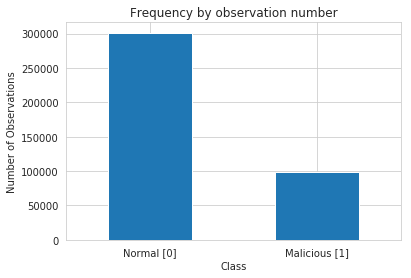

In [9]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [10]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [11]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [12]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [13]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, 48].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, 48].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, 48].sum()/test_df.shape[0])

0.24702734375
0.24565625
0.2468875


In [14]:
train_x = train_df.iloc[:, :48] 
dev_x = dev_df.iloc[:, :48] 
test_x = test_df.iloc[:, :48] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [15]:
# Define the final train and test sets
train_y = train_df.iloc[:, 48]
dev_y = dev_df.iloc[:, 48]
test_y = test_df.iloc[:, 48]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [16]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

48


### Autoencoder Function

encoding_dim - 2

Epoch 94/300 78596/78596 [==============================] - 10s 125us/step 
- loss: 3.8990e-05 - acc: 0.0237 - 
        val_loss: 3.9704e-05 - val_acc: 0.0236

In [17]:
def ae(factor_enc_dim, output_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activation='relu', name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=output_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [18]:
def sae(factor_enc_dim, output_activation,
        optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activation='relu', name='input_layer')(input_data)
    encoded = Dense(int(encoding_dim/2), activation='relu')(encoded) ##Stacked AE
    encoded_bottle_neck = Dense(int(encoding_dim/4), activation='relu', name='enc_bottle_neck')(encoded) ##Stacked AE
    
    ### Define decoding layer
    decoded = Dense(int(encoding_dim/2), activation='relu')(encoded_bottle_neck) ##Stacked AE
    decoded = Dense(encoding_dim, activation='relu')(decoded) ##Stacked AE
    decoded = Dense(train_x.shape[1], activation=output_activation)(decoded)
    
    ### Create the autoencoder model
    sae = Model(input_data, decoded)
    sae.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    
    print(sae.summary())

    encoder = Model(input_data, encoded_bottle_neck)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return sae,encoded_train_x,encoded_test_x

In [19]:
def spae(factor_enc_dim, output_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation='relu', name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=output_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [20]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=1,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    elapsed_time = (time.time() - start_time)
    print("--- AE spent %s seconds ---" % elapsed_time)
    
    return hist_auto

In [21]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Autoencoder model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [22]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(24, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [23]:
def ann_1h_36n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [24]:
def ann_1h_24n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(24, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [25]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=1)

    elapsed_time = (time.time() - start_time)
    print("--- ANN spent %s seconds ---" % elapsed_time)

    return history

In [26]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01))
    
    return pred_ann_prob, pred_ann_01

In [27]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()
    

In [28]:
ae_sigmoid_adam_logcosh,enc_train_x_asal,enc_test_x_asal = ae(factor_enc_dim = 1.5,
                                                              output_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
#ae_sigmoid_adam_logcosh = load_model('ae_sigmoid_adam_logcosh_redds10bal.h5')

In [30]:
hist_ae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "ae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = ae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Tue Jun  4 20:44:20 2019
Instructions for updating:
Use tf.cast instead.
Train on 256000 samples, validate on 64000 samples
Epoch 1/200
256000/256000 [==============================] - 17s 65us/step - loss: 0.0034 - acc: 0.0295 - val_loss: 1.1949e-04 - val_acc: 0.0719
Epoch 2/200
256000/256000 [==============================] - 15s 61us/step - loss: 6.1779e-05 - acc: 0.0862 - val_loss: 4.2881e-05 - val_acc: 0.0860
Epoch 3/200
256000/256000 [==============================] - 14s 53us/step - loss: 4.1166e-05 - acc: 0.0917 - val_loss: 4.0791e-05 - val_acc: 0.0835
Epoch 4/200
256000/256000 [==============================] - 13s 52us/step - loss: 4.0164e-05 - acc: 0.0748 - val_loss: 4.0291e-05 - val_acc: 0.0729
Epoch 5/200
256000/256000 [==============================] - 14s 54us/step - loss: 3.9852e-05 - acc: 0.0634 - val_loss: 4.0045e-05 - val_acc: 0.0635
Epoch 6/200
256000/256000 [==============================] - 13s 53us/step - loss: 3.9596e-05 - acc: 0.0590 - val_loss: 3.9893e-05 - va

Best loss value: 1.0974173678789612e-05


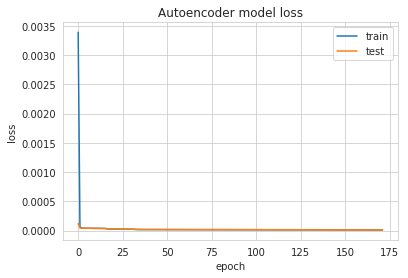

In [31]:
best_loss_value_ae_sigmoid_adam_logcosh = plot_hist_auto(hist_ae_sigmoid_adam_logcosh, './Figures/ae_sigmoid_adam_logcosh.png')

In [32]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          output_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [34]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "ae_sigmoid_adam_mse_redds10bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = 48,
                                  shuffle = False)

Tue Jun  4 21:25:26 2019
Train on 256000 samples, validate on 64000 samples
Epoch 1/200
256000/256000 [==============================] - 15s 58us/step - loss: 0.0067 - acc: 0.0170 - val_loss: 2.0291e-04 - val_acc: 0.0291
Epoch 2/200
256000/256000 [==============================] - 15s 60us/step - loss: 1.2041e-04 - acc: 0.0343 - val_loss: 8.7786e-05 - val_acc: 0.0266
Epoch 3/200
256000/256000 [==============================] - 15s 59us/step - loss: 8.3455e-05 - acc: 0.0229 - val_loss: 8.1148e-05 - val_acc: 0.0178
Epoch 4/200
256000/256000 [==============================] - 16s 61us/step - loss: 8.0796e-05 - acc: 0.0206 - val_loss: 8.0295e-05 - val_acc: 0.0254
Epoch 5/200
256000/256000 [==============================] - 15s 59us/step - loss: 8.0012e-05 - acc: 0.0265 - val_loss: 7.9705e-05 - val_acc: 0.0287
Epoch 6/200
256000/256000 [==============================] - 16s 61us/step - loss: 7.9210e-05 - acc: 0.0348 - val_loss: 7.8824e-05 - val_acc: 0.0406
Epoch 7/200
256000/256000 [=======

Best loss value: 3.331291746292209e-05


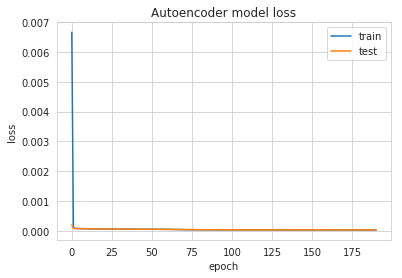

In [35]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

In [36]:
sae_sigmoid_adam_mse,enc_train_x_ssam,enc_test_x_ssam = sae(factor_enc_dim = 1.5,
                                                          output_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48)                0         
_________________________________________________________________
input_layer (Dense)          (None, 32)                1568      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
enc_bottle_neck (Dense)      (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 48)                1584      
Total para

In [37]:
#sae_sigmoid_adam_mse = load_model('sae_sigmoid_adam_mse_redds10bal.h5')

In [38]:
hist_sae_sigmoid_adam_mse = fit_ae(checkpoint_file = "sae_sigmoid_adam_mse_redds10bal.h5",
                                        autoencoder = sae_sigmoid_adam_mse, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Tue Jun  4 22:14:09 2019
Train on 256000 samples, validate on 64000 samples
Epoch 1/200
256000/256000 [==============================] - 21s 84us/step - loss: 0.0220 - acc: 0.1879 - val_loss: 0.0119 - val_acc: 0.3451
Epoch 2/200
256000/256000 [==============================] - 22s 85us/step - loss: 0.0100 - acc: 0.3729 - val_loss: 0.0092 - val_acc: 0.3995
Epoch 3/200
256000/256000 [==============================] - 22s 84us/step - loss: 0.0091 - acc: 0.4101 - val_loss: 0.0088 - val_acc: 0.4290
Epoch 4/200
256000/256000 [==============================] - 21s 83us/step - loss: 0.0088 - acc: 0.4170 - val_loss: 0.0085 - val_acc: 0.4439
Epoch 5/200
256000/256000 [==============================] - 22s 84us/step - loss: 0.0084 - acc: 0.4214 - val_loss: 0.0083 - val_acc: 0.3808
Epoch 6/200
256000/256000 [==============================] - 21s 83us/step - loss: 0.0083 - acc: 0.3721 - val_loss: 0.0082 - val_acc: 0.3527
Epoch 7/200
256000/256000 [==============================] - 21s 84us/step - l

Best loss value: 0.005147667305864161


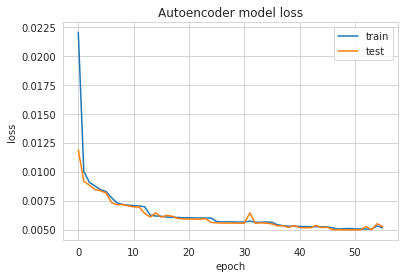

In [39]:
best_loss_value_sae_sigmoid_adam_mse  = plot_hist_auto(hist_sae_sigmoid_adam_mse, './Figures/hist_sae_sigmoid_adam_mse.png')

In [40]:
sae_sigmoid_adam_logcosh,enc_train_x_ssal,enc_test_x_ssal = sae(factor_enc_dim = 1.5,
                                                              output_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48)                0         
_________________________________________________________________
input_layer (Dense)          (None, 32)                1568      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
enc_bottle_neck (Dense)      (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_10 (Dense)             (None, 48)                1584      
Total para

In [41]:
from keras.utils import plot_model 
plot_model(sae_sigmoid_adam_logcosh, to_file='sae_sigmoid_adam_logcosh.png')
from PIL import Image
image = Image.open('sae_sigmoid_adam_logcosh.png')
image.show()

In [42]:
#sae_sigmoid_adam_logcosh = load_model('sae_sigmoid_adam_logcosh_redds10bal.h5')

In [43]:
hist_sae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "sae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = sae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Tue Jun  4 22:34:19 2019
Train on 256000 samples, validate on 64000 samples
Epoch 1/200
256000/256000 [==============================] - 22s 87us/step - loss: 0.0104 - acc: 0.0525 - val_loss: 0.0061 - val_acc: 0.1397
Epoch 2/200
256000/256000 [==============================] - 22s 85us/step - loss: 0.0055 - acc: 0.1419 - val_loss: 0.0048 - val_acc: 0.1692
Epoch 3/200
256000/256000 [==============================] - 22s 85us/step - loss: 0.0046 - acc: 0.1767 - val_loss: 0.0045 - val_acc: 0.2126
Epoch 4/200
256000/256000 [==============================] - 22s 86us/step - loss: 0.0045 - acc: 0.1955 - val_loss: 0.0043 - val_acc: 0.1910
Epoch 5/200
256000/256000 [==============================] - 22s 85us/step - loss: 0.0042 - acc: 0.2221 - val_loss: 0.0041 - val_acc: 0.2062
Epoch 6/200
256000/256000 [==============================] - 22s 86us/step - loss: 0.0041 - acc: 0.2842 - val_loss: 0.0043 - val_acc: 0.2807
Epoch 7/200
256000/256000 [==============================] - 22s 85us/step - l

Best loss value: 0.003662414710805024


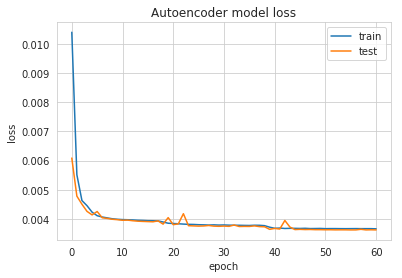

In [44]:
best_loss_value_sae_sigmoid_adam_logcosh  = plot_hist_auto(hist_sae_sigmoid_adam_logcosh, './Figures/hist_sae_sigmoid_adam_logcosh.png')

In [45]:
spae_sigmoid_adam_logcosh,enc_train_x_spaesal,enc_test_x_spaesal = ae(factor_enc_dim = 1.5,
                                                              output_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_11 (Dense)             (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
#spae_sigmoid_adam_logcosh = load_model('spae_sigmoid_adam_logcosh_redds10bal.h5')

In [47]:
hist_spae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "spae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = spae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Tue Jun  4 22:55:34 2019
Train on 256000 samples, validate on 64000 samples
Epoch 1/200
256000/256000 [==============================] - 15s 57us/step - loss: 0.0032 - acc: 0.0052 - val_loss: 1.0716e-04 - val_acc: 0.0046
Epoch 2/200
256000/256000 [==============================] - 15s 58us/step - loss: 5.9905e-05 - acc: 0.0096 - val_loss: 4.6952e-05 - val_acc: 0.0086
Epoch 3/200
256000/256000 [==============================] - 15s 57us/step - loss: 4.3461e-05 - acc: 0.0124 - val_loss: 4.0257e-05 - val_acc: 0.0109
Epoch 4/200
256000/256000 [==============================] - 15s 57us/step - loss: 4.0266e-05 - acc: 0.0146 - val_loss: 3.9904e-05 - val_acc: 0.0126
Epoch 5/200
256000/256000 [==============================] - 15s 58us/step - loss: 3.9876e-05 - acc: 0.0160 - val_loss: 3.9686e-05 - val_acc: 0.0141
Epoch 6/200
256000/256000 [==============================] - 15s 57us/step - loss: 3.9554e-05 - acc: 0.0162 - val_loss: 3.9570e-05 - val_acc: 0.0144
Epoch 7/200
256000/256000 [=======

Best loss value: 2.397789587348598e-05


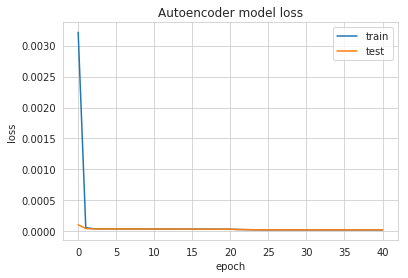

In [48]:
best_loss_value_spae_sigmoid_adam_logcosh = plot_hist_auto(hist_spae_sigmoid_adam_logcosh, './Figures/spae_sigmoid_adam_logcosh.png')

In [49]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_logcosh': best_loss_value_ae_sigmoid_adam_logcosh,
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_sae_sigmoid_adam_logcosh': best_loss_value_sae_sigmoid_adam_logcosh,
    'loss_value_sae_sigmoid_adam_mse': best_loss_value_sae_sigmoid_adam_mse,
    'loss_value_spae_sigmoid_adam_logcosh': best_loss_value_spae_sigmoid_adam_logcosh,
    }

In [50]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_logcosh': 1.0974173678789612e-05,
 'loss_value_ae_sigmoid_adam_mse': 3.331291746292209e-05,
 'loss_value_sae_sigmoid_adam_logcosh': 0.003662414710805024,
 'loss_value_sae_sigmoid_adam_mse': 0.005147667305864161,
 'loss_value_spae_sigmoid_adam_logcosh': 2.397789587348598e-05}

In [51]:
print(enc_train_x_asal.shape[1])
print(enc_test_x_asal.shape[1])

print(enc_train_x_spaesal.shape[1])
print(enc_test_x_spaesal.shape[1])

print(enc_train_x_asam.shape[1])
print(enc_test_x_asam.shape[1])

print(enc_train_x_ssal.shape[1])
print(enc_test_x_ssal.shape[1])

print(enc_train_x_ssam.shape[1])
print(enc_test_x_ssam.shape[1])

32
32
32
32
32
32
8
8
8
8


In [52]:
print(enc_train_x_asal.shape)
print(enc_test_x_asal.shape)

(256000, 32)
(80000, 32)


In [53]:
ann36n_unisoftsigbinlosadam = ann_1h_36n(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_13 (Dense)             (None, 36)                1764      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 37        
Total params: 3,529
Trainable params: 3,457
Non-trainable params: 72
_________________________________________________________________
None


In [54]:
hist_ann36n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = False,
                                        batch_size = 48)

Tue Jun  4 23:05:32 2019
Train on 204800 samples, validate on 51200 samples
Epoch 1/200
204800/204800 [==============================] - 19s 93us/step - loss: 0.4774 - acc: 0.7700 - val_loss: 0.4622 - val_acc: 0.7816
Epoch 2/200
204800/204800 [==============================] - 18s 90us/step - loss: 0.4455 - acc: 0.7918 - val_loss: 0.4357 - val_acc: 0.7958
Epoch 3/200
204800/204800 [==============================] - 18s 89us/step - loss: 0.4326 - acc: 0.8002 - val_loss: 0.4355 - val_acc: 0.7966
Epoch 4/200
204800/204800 [==============================] - 18s 89us/step - loss: 0.4231 - acc: 0.8069 - val_loss: 0.4076 - val_acc: 0.8157
Epoch 5/200
204800/204800 [==============================] - 18s 89us/step - loss: 0.4159 - acc: 0.8108 - val_loss: 0.4095 - val_acc: 0.8150
Epoch 6/200
204800/204800 [==============================] - 19s 91us/step - loss: 0.4099 - acc: 0.8135 - val_loss: 0.4056 - val_acc: 0.8172
Epoch 7/200
204800/204800 [==============================] - 18s 89us/step - l

Best loss value: 0.33351943914662113


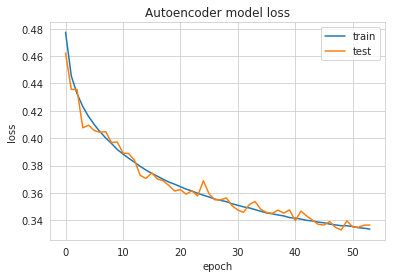

In [55]:
best_loss_value_ann36n_unisoftsigbinlosadam = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam, './Figures/ann36_unisoftsigbinlosadam.png')

In [56]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam = ann_predict(ann36n_unisoftsigbinlosadam,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.848325
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     60249
           1       0.76      0.56      0.65     19751

   micro avg       0.85      0.85      0.85     80000
   macro avg       0.81      0.75      0.78     80000
weighted avg       0.84      0.85      0.84     80000



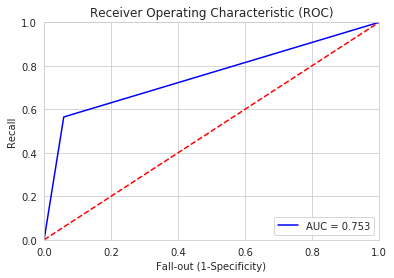

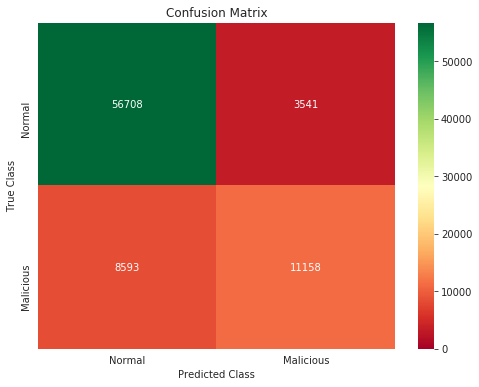

In [57]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [58]:
ann24n_unisoftsigbinlosadam = ann_1h_24n(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_16 (Dense)             (None, 24)                1176      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24)                96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 2,881
Trainable params: 2,833
Non-trainable params: 48
_________________________________________________________________
None


In [59]:
hist_ann24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann24n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Tue Jun  4 23:22:36 2019
Train on 204800 samples, validate on 51200 samples
Epoch 1/200
204800/204800 [==============================] - 21s 103us/step - loss: 0.4900 - acc: 0.7657 - val_loss: 0.4653 - val_acc: 0.7869
Epoch 2/200
204800/204800 [==============================] - 20s 100us/step - loss: 0.4606 - acc: 0.7847 - val_loss: 0.4501 - val_acc: 0.7929
Epoch 3/200
204800/204800 [==============================] - 21s 101us/step - loss: 0.4518 - acc: 0.7901 - val_loss: 0.4508 - val_acc: 0.7934
Epoch 4/200
204800/204800 [==============================] - 20s 100us/step - loss: 0.4460 - acc: 0.7935 - val_loss: 0.4381 - val_acc: 0.7966
Epoch 5/200
204800/204800 [==============================] - 20s 99us/step - loss: 0.4389 - acc: 0.7987 - val_loss: 0.4302 - val_acc: 0.8007
Epoch 6/200
204800/204800 [==============================] - 21s 102us/step - loss: 0.4333 - acc: 0.8006 - val_loss: 0.4185 - val_acc: 0.8060
Epoch 7/200
204800/204800 [==============================] - 20s 100us/st

Best loss value: 0.35875413233647124


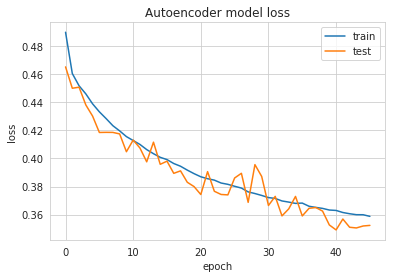

In [60]:
best_loss_value_ann24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann24n_unisoftsigbinlosadam, './Figures/ann24_unisoftsigbinlosadam.png')

In [61]:
pred_ann24n_prob_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam = ann_predict(ann24n_unisoftsigbinlosadam,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.837675
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     60249
           1       0.83      0.43      0.57     19751

   micro avg       0.84      0.84      0.84     80000
   macro avg       0.84      0.70      0.73     80000
weighted avg       0.84      0.84      0.82     80000



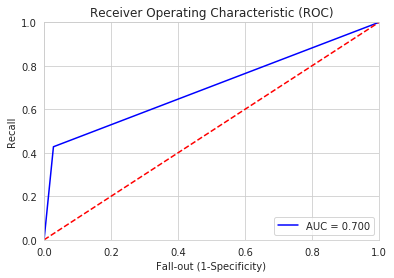

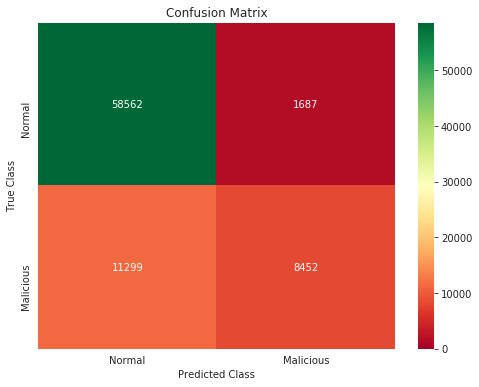

In [62]:
plot_roc_cm(pred_ann24n_01_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam, './Figures/ROC_ann24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann24n_unisoftsigbinlosadam_redds10bal.png')

In [63]:
ann_2h_unisoftsigbinlosadam = ann_2h(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_19 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_20 (Dense)             (None, 24)                888       
_________________________________________________________________
batch_normalization_3 (Batch (None, 24)                96        
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 25        
Total params: 4,357
Trainable params: 4,309
Non-trainable params: 48
_________________________________________________________________
None


In [64]:
hist_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Tue Jun  4 23:38:25 2019
Train on 204800 samples, validate on 51200 samples
Epoch 1/200
204800/204800 [==============================] - 23s 112us/step - loss: 0.4909 - acc: 0.7638 - val_loss: 0.4570 - val_acc: 0.7885
Epoch 2/200
204800/204800 [==============================] - 22s 106us/step - loss: 0.4498 - acc: 0.7911 - val_loss: 0.4297 - val_acc: 0.8080
Epoch 3/200
204800/204800 [==============================] - 22s 106us/step - loss: 0.4317 - acc: 0.8041 - val_loss: 0.4156 - val_acc: 0.8149
Epoch 4/200
204800/204800 [==============================] - 22s 108us/step - loss: 0.4187 - acc: 0.8115 - val_loss: 0.4139 - val_acc: 0.8113
Epoch 5/200
204800/204800 [==============================] - 22s 106us/step - loss: 0.4084 - acc: 0.8167 - val_loss: 0.4062 - val_acc: 0.8117
Epoch 6/200
204800/204800 [==============================] - 22s 107us/step - loss: 0.4005 - acc: 0.8208 - val_loss: 0.3963 - val_acc: 0.8245
Epoch 7/200
204800/204800 [==============================] - 22s 107us/s

Best loss value: 0.3250638534000609


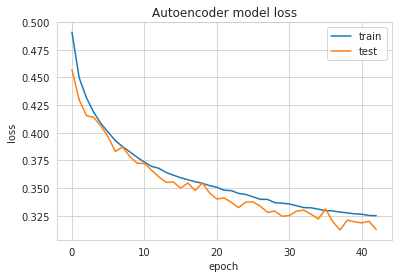

In [65]:
best_loss_value_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam, './Figures/ann_2h_unisoftsigbinlosadam.png')

In [66]:
pred_ann_2h_prob_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam = ann_predict(ann_2h_unisoftsigbinlosadam,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.8630625
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     60249
           1       0.82      0.57      0.67     19751

   micro avg       0.86      0.86      0.86     80000
   macro avg       0.85      0.77      0.79     80000
weighted avg       0.86      0.86      0.85     80000



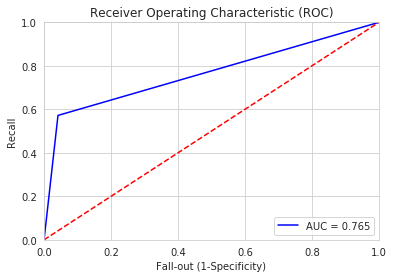

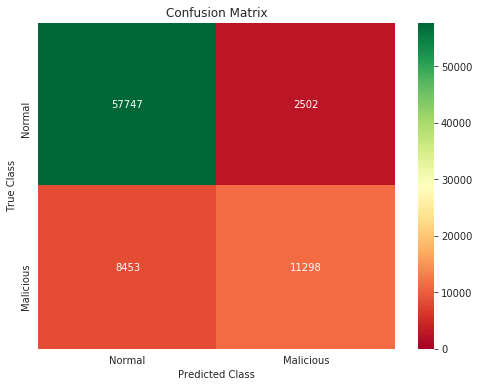

In [67]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ann_2h_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam_redds10bal.png')

In [68]:
ann_24n_unisoftsigbinlosadam = ann_1h_24n(neurons=48,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_23 (Dense)             (None, 24)                1176      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24)                96        
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 25        
Total params: 3,649
Trainable params: 3,601
Non-trainable params: 48
_________________________________________________________________
None


In [69]:
hist_ann_24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_24n_unisoftsigbinlosadam,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Tue Jun  4 23:54:14 2019
Train on 204800 samples, validate on 51200 samples
Epoch 1/200
204800/204800 [==============================] - 22s 109us/step - loss: 0.4719 - acc: 0.7730 - val_loss: 0.4436 - val_acc: 0.7936
Epoch 2/200
204800/204800 [==============================] - 21s 104us/step - loss: 0.4356 - acc: 0.7964 - val_loss: 0.4202 - val_acc: 0.8054
Epoch 3/200
204800/204800 [==============================] - 21s 104us/step - loss: 0.4164 - acc: 0.8083 - val_loss: 0.4025 - val_acc: 0.8163
Epoch 4/200
204800/204800 [==============================] - 22s 106us/step - loss: 0.4040 - acc: 0.8170 - val_loss: 0.3865 - val_acc: 0.8324
Epoch 5/200
204800/204800 [==============================] - 21s 104us/step - loss: 0.3935 - acc: 0.8225 - val_loss: 0.3828 - val_acc: 0.8272
Epoch 6/200
204800/204800 [==============================] - 21s 105us/step - loss: 0.3838 - acc: 0.8279 - val_loss: 0.3847 - val_acc: 0.8241
Epoch 7/200
204800/204800 [==============================] - 22s 106us/s

Best loss value: 0.3042129120021127


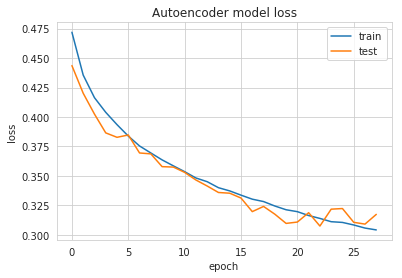

In [70]:
best_loss_value_ann_24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann_24n_unisoftsigbinlosadam, './Figures/ann_24_unisoftsigbinlosadam.png')

In [71]:
pred_ann_24n_prob_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam = ann_predict(ann_24n_unisoftsigbinlosadam,test_x)

Overall accuracy of Neural Network model: 0.8583
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     60249
           1       0.78      0.59      0.67     19751

   micro avg       0.86      0.86      0.86     80000
   macro avg       0.83      0.77      0.79     80000
weighted avg       0.85      0.86      0.85     80000



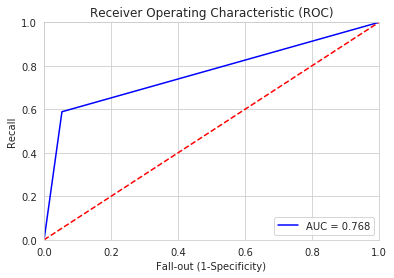

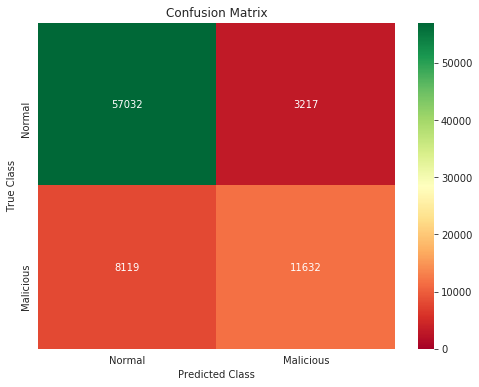

In [72]:
plot_roc_cm(pred_ann_24n_01_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam, './Figures/ROC_ann_24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_24n_unisoftsigbinlosadam_redds10bal.png')

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
#                              min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.5, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [ ]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_asal, train_y)

pred_y_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_asal),
                              y=test_y,
                              cv=KFold(n_splits=10, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_RF,digits=4))

Wed Jun  5 11:18:01 2019


In [ ]:
plot_roc_cm(pred_y_RF, pred_y_RF, './Figures/ROC_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png', './Figures/CM_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png')